<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
matplotlib 2.0.2
statsmodels 0.8.0
sklearn 0.19.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : d3a49ffa697851dc433a7fe9a1ec39a193159910


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = './data/'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1) 

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
''' ВАШ КОД ЗДЕСЬ '''
cross_val_score(estimator=knn, X=X_train, y=y_train, scoring="accuracy", cv=skf, n_jobs=-1).mean()

0.56471888700633621

In [13]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1) 
knn.fit(X_train, y_train)
accuracy_score(knn.predict(X_valid), y_valid)

0.58402465039108797

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
print("oob score = " + str(forest.oob_score_))
predictions = forest.predict(X_valid)
accuracy_score(predictions, y_valid)

oob score = 0.722718959561


0.72884569803270916

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

In [ ]:
!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [16]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [17]:
logit = LogisticRegression(random_state=17)
print(cross_val_score(estimator=logit, X=X_train, y=y_train, scoring="accuracy", cv=skf, n_jobs=-1).mean())


0.761026754367


In [18]:
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train)
predictions = logit.predict(X_valid)
print(accuracy_score(predictions, y_valid))

0.781701825077


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial',cv=skf, verbose=True, n_jobs=-1, random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.2s finished


Wall time: 35.2 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [20]:
sum(logit_grid_searcher1.scores_[241])/3

array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
        0.75137565,  0.75899587,  0.75686429,  0.74995626,  0.73867821])

In [21]:
logit_mean_cv_scores1 = sum(logit_grid_searcher1.scores_[241])/3

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [22]:
''' ВАШ КОД ЗДЕСЬ '''
import operator
scores = list(zip(logit_c_values1, logit_mean_cv_scores1))
sorted(scores, key=operator.itemgetter(1), reverse=True)

[(1.0, 0.75899587289580583),
 (4.6415888336127722, 0.7568642941986865),
 (0.21544346900318823, 0.75137564905546084),
 (21.544346900318821, 0.74995625825270384),
 (100.0, 0.73867820781645754),
 (0.046415888336127774, 0.71297117025530243),
 (0.01, 0.65119284650608078),
 (0.0021544346900318821, 0.55273511787141993),
 (0.00046415888336127773, 0.47337913259135345),
 (0.0001, 0.31822224699435825)]

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

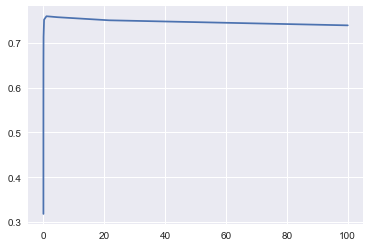

In [23]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [24]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial',cv=skf, verbose=True, n_jobs=-1, random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


Wall time: 1min 59s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores2 = sum(logit_grid_searcher2.scores_[241])/3

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [26]:
''' ВАШ КОД ЗДЕСЬ '''
import operator
scores = list(zip(logit_c_values2, logit_mean_cv_scores2))
sorted(scores, key=operator.itemgetter(1), reverse=True)

[(0.4631578947368421, 0.75868969438643674),
 (0.82631578947368423, 0.75848780413985573),
 (1.9157894736842107, 0.75828569720647154),
 (1.5526315789473686, 0.75808170251215967),
 (2.2789473684210528, 0.75798088084172155),
 (1.1894736842105265, 0.75767442401824814),
 (2.642105263157895, 0.75737149581092511),
 (3.7315789473684213, 0.75716963617974509),
 (3.0052631578947371, 0.7570672984946839),
 (3.3684210526315792, 0.75686494386259662),
 (4.094736842105263, 0.75666178450709731),
 (4.4578947368421051, 0.75595074246704996),
 (4.8210526315789473, 0.75564608076530249),
 (5.1842105263157894, 0.75534240985836865),
 (5.5473684210526315, 0.75473314847867412),
 (5.9105263157894736, 0.75463211051793222),
 (6.2736842105263158, 0.75453045350868153),
 (6.6368421052631579, 0.75442919886113646),
 (7.0, 0.7539210374659846),
 (0.10000000000000001, 0.73542669834555785)]

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

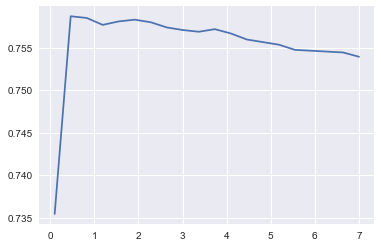

In [27]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [28]:
logit_cv_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)
logit_cv_acc

0.7748281583313581

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [29]:
from sklearn.svm import LinearSVC

In [30]:
svm = LinearSVC(C=1, random_state=17)
print(cross_val_score(estimator=svm, X=X_train, y=y_train, scoring="accuracy", cv=skf, n_jobs=-1).mean())

0.752797672301


In [31]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)
predictions = logit.predict(X_valid)
print(accuracy_score(predictions, y_valid))

0.781701825077


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [32]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=LinearSVC(random_state=17), param_grid=svm_params1, n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 23 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [33]:
''' ВАШ КОД ЗДЕСЬ '''
list(zip(svm_params1['C'], svm_grid_searcher1.cv_results_['mean_test_score']))

[(0.0001, 0.55872790083316404),
 (1111.1112000000001, 0.67780938833570414),
 (2222.2223000000004, 0.68268644584434057),
 (3333.3334000000004, 0.68451534241007927),
 (4444.4445000000005, 0.68309286730339358),
 (5555.5556000000006, 0.66449908555171711),
 (6666.6667000000007, 0.67293233082706772),
 (7777.7778000000008, 0.68319447266815692),
 (8888.8888999999999, 0.65748831538305219),
 (10000.0, 0.65352570615728511)]

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

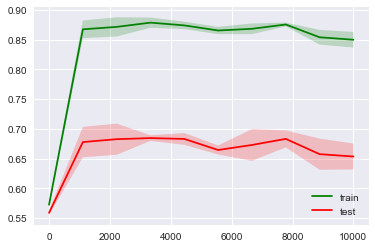

In [34]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [35]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(estimator=LinearSVC(random_state=17), param_grid=svm_params2, n_jobs=-1, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 33.6 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [36]:
''' ВАШ КОД ЗДЕСЬ '''
list(zip(svm_params2['C'], svm_grid_searcher2.cv_results_['mean_test_score']))

[(0.001, 0.66287339971550496),
 (0.035448275862068966, 0.75848404795773217),
 (0.069896551724137931, 0.76254826254826258),
 (0.10434482758620689, 0.76468197520829095),
 (0.13879310344827586, 0.76336110546636859),
 (0.17324137931034483, 0.76285307864255236),
 (0.20768965517241378, 0.76224344645397279),
 (0.24213793103448275, 0.76173541963015645),
 (0.27658620689655172, 0.76122739280634022),
 (0.31103448275862067, 0.76092257671205044),
 (0.34548275862068967, 0.76051615525299732),
 (0.37993103448275861, 0.76061776061776065),
 (0.41437931034482756, 0.75980491769965453),
 (0.44882758620689656, 0.75899207478154851),
 (0.4832758620689655, 0.75838244259296894),
 (0.51772413793103444, 0.75736638894533637),
 (0.55217241379310344, 0.75746799431009959),
 (0.58662068965517244, 0.75706157285104658),
 (0.62106896551724133, 0.75655354602723024),
 (0.65551724137931033, 0.75655354602723024),
 (0.68996551724137933, 0.75624872993294046),
 (0.72441379310344822, 0.7560455192034139),
 (0.75886206896551722, 0

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

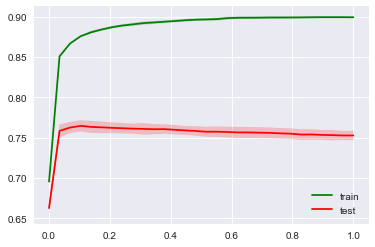

In [37]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [38]:
C=0.10434482758620689
svm_cv_acc = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)

In [39]:
svm_cv_acc

0.78075373311211183

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [69]:
''' ВАШ КОД ЗДЕСЬ '''
0.764681975208291
0.7807537331121118

0.7807537331121118

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [40]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_pkl:
        X_sparse = pickle.load(X_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, 
                                                          random_state=17, stratify=y)
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
    cv_score = cross_val_score(estimator=estimator, X=X_train, y=y_train, scoring="accuracy", cv=skf, n_jobs=-1).mean()
    
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_valid)
    valid_score = accuracy_score(predictions, y_valid)
    return (cv_score, valid_score)

**Убедитесь, что функция работает.**

In [41]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76468532445509807, 0.78075373311211183)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [42]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [43]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print(str(window_size) + " " + str(session_length))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

10 15
(0.82382149552781048, 0.84048352690210948)
10 10
(0.76468532445509807, 0.78075373311211183)
7 15
(0.84794037698440983, 0.85432221669155473)
7 10
(0.79701614637346518, 0.80736684917869583)
7 7
(0.75298911148303416, 0.76173884187821472)
5 15
(0.86800137255434695, 0.87529634898055952)
5 10
(0.81592472053180387, 0.82456140350877194)
5 7
(0.77405867456322597, 0.78532479848269321)
5 5
(0.72528306503988282, 0.73624940730203892)
Wall time: 33.5 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [82]:
(0.868001372554347, 0.8752963489805595)

(0.868001372554347, 0.8752963489805595)

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [44]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print(str(window_size) + " " + str(session_length))
    print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

5 5
(0.40858659509908596, 0.42171606560568453)
7 7
(0.43638649409423974, 0.45295840855673264)
10 10
(0.46125889994279129, 0.48362769425388019)
Wall time: 14min 38s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [84]:
(0.4612588999427913, 0.4836276942538802)


(0.4612588999427913, 0.4836276942538802)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [45]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [46]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [47]:
%%time
C = [0.4631578947368421]
logit_cv_150users = LogisticRegressionCV(Cs=C, multi_class='ovr', n_jobs=-1, random_state=17, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 13min 44s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [89]:
logit_cv_150users.scores_

{6: array([[0.9961279 ],
        [0.9959019 ],
        [0.99548915]]), 13: array([[0.99628404],
        [0.99615216],
        [0.99627228]]), 15: array([[0.99519111],
        [0.99505725],
        [0.99517589]]), 16: array([[0.99203722],
        [0.99202277],
        [0.99122889]]), 28: array([[0.99003872],
        [0.98998936],
        [0.99006986]]), 31: array([[0.99450412],
        [0.9947757 ],
        [0.99451806]]), 33: array([[0.99362978],
        [0.99374335],
        [0.99351565]]), 39: array([[0.98597927],
        [0.98532816],
        [0.98593491]]), 46: array([[0.99806395],
        [0.99768504],
        [0.99818313]]), 49: array([[0.99503497],
        [0.99474442],
        [0.99501927]]), 50: array([[0.99425431],
        [0.99468185],
        [0.99451806]]), 53: array([[0.99362978],
        [0.99371207],
        [0.99348432]]), 65: array([[0.99697102],
        [0.99693424],
        [0.99708674]]), 66: array([[0.99509743],
        [0.99490083],
        [0.99489396]]), 82: ar

In [48]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, c))

NameError: name 'c' is not defined

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [93]:
np.bincount([1,3,4,3,4])


array([0, 1, 0, 2, 2])

In [49]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    cv_score = logit_cv_150users.scores_[user_id].mean()
    total = len(y_train_150)
    default = (total - class_distr[user_id]) / total
    acc_diff_vs_constant.append(cv_score - default)

In [50]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

AttributeError: 'list' object has no attribute 'values'

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [52]:
acc_diff_vs_constant = np.asarray(acc_diff_vs_constant)
num_better = np.array(acc_diff_vs_constant > 0).sum()
np.array(acc_diff_vs_constant > 0)
num_better / 150

0.91333333333333333

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.